# 2020-05-07
## Segmenting nuclei from lattice stacks

I'm picking up where the last notebook (2020-04-30) left off, trying to get some clean code together to put into my image processing module. The last notebook describes kind of a wild journey, but the most promising strategy at this point is to use background subtraction from the red channel, which removes embryo boundary and other non-specific background. Background subtraction is followed by smooth, threshold, clean up with morphological processing, then label. This works exceptionally well for early stages with well-spaced nuclei. For densely-packed nuclei, it had the problem of connecting nearby nuclei. I'm going to try to extend this approach using watershed to separate connected nuclei.

In [2]:
# Import public packages.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
# from skimage import filters, measure, segmentation, transform, exposure, img_as_ubyte, feature, morphology
#from skimage import filters, io
from functools import partial
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [22]:
# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import (read_tiff_folder, read_tiff_lattice, viewer, viewer, 
                    segment_embryo, labelmask_apply_morphology, zstack_normalize_mean,
                   peak_local_max_nD, gradient_nD, labelmask_filter_objsize, filter_labelmask,
                   object_circularity)
import imagep as imp
reload(imp);

In [4]:
# Load stack.
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/',
    span=(0,3))

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [56]:
from skimage.filters.thresholding import threshold_otsu
from skimage.segmentation import watershed

def segment_nuclei3D_3(instack, sigma1=3, sigma_grad=5, seed_window=(70,100,100), erosion_length=10, dilation_length=10, 
                       size_min=1e4, size_max=7.5e5, circularity_min=10):
    """Segment nuclei from a 3D imaging stack
   
    Args:
        stack: ndarray
            3D image stack of dimensions [z, x, y].
        sigma_big: int
            Sigma for larger Gaussian filter
        sigma_small: int
            Sigma for smaller Gaussian filter
        dilation_length: int
            Size in x and y of structuring element for dilating objects
        size_min: int
            Minimum size, in pixels, of objects to retain
        size_max: int
            Maximum size, in pixels, of objects to retain
        circularity_min: float
            Minimum circularity measure of objects to retain
    
    Returns:
        labelmask: ndarray
            Mask of same shape as input stack with nuclei segmented and labeled
    
    """
    # Normalize each Z-slice to mean intensity to account for uneven illumination.
    stack = zstack_normalize_mean(instack)
    # Apply gaussian filter.
    stack_smooth = ndi.filters.gaussian_filter(stack, sigma=sigma1)
    # Threshold, make binary mask, fill.
    t = threshold_otsu(stack_smooth)
    mask = np.where(stack_smooth >= t, 1, 0)
    mask = imp.imfill(mask, (0,0,100))
    # Use morphological erosion to remove spurious connections between objects.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erosion_length, erosion_length)))
    # Perform distance transform of mask.
    dist = ndi.distance_transform_edt(mask)
    # Find local maxima for watershed seeds.
    seeds, _ = peak_local_max_nD(dist, size=seed_window)
    # Do gradient transform to get substrate for watershedding.
    stack_smooth2 = ndi.filters.gaussian_filter(stack, sigma=sigma_grad)
    grad = gradient_nD(stack_smooth2)
    # Segment by watershed algorithm.
    ws = watershed(grad, seeds.astype(int))
    # Filter nuclei for size and circularity.
    labelmask = labelmask_filter_objsize(ws, size_min, size_max)
    labelmask = filter_labelmask(labelmask, object_circularity, circularity_min, 1000)
    # Lightly dilate labeled structures.
    labelmask = labelmask_apply_morphology(labelmask, 
            mfunc=ndi.morphology.binary_dilation, 
            struct=np.ones((1, dilation_length, dilation_length)), 
            expand_size=(1, dilation_length + 1, dilation_length + 1))
    
    return labelmask

def stack_bgsub(stack, bgchannel=0, fgchannel=1):
    bg = stack[bgchannel].mean(axis=0)
    scale = stack[fgchannel].mean() / bg.mean()
    bgsub = stack - (scale * bg)
    bgsub = bgsub + abs(bgsub.min())
    return bgsub


In [32]:
# Background subtract red from green channel.
stack_bgs = stack_bgsub(stack)

TypeError: stack_bgsub() got an unexpected keyword argument 'seed_window'

In [8]:
# Make test 3D stack.
test = stack_bgs[1,0]

In [57]:
a=segment_nuclei3D_3(test, seed_window=(70,50,50))

In [58]:
viewer(np.where(a, stack[1,0], 0),'zxy')
#plt.imshow(test.max(axis=0), alpha=0.5)
#plt.imshow(a1.max(axis=0), alpha=0.5)

interactive(children=(Dropdown(description='Color', index=1, options=('cividis', 'viridis', 'gray_r', 'Reds', …

This looks great. Let's try a different stack...

In [59]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em1_mv1/',
    span=(30,33))
stack_bgs = stack_bgsub(stack)
test = stack_bgs[1,0]
b=segment_nuclei3D_3(test, seed_window=(70,50,50))

/Users/MStadler/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2135: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [60]:
viewer([test,b*30], 'zxy')

interactive(children=(Dropdown(description='Color', index=1, options=('cividis', 'viridis', 'gray_r', 'Reds', …

Looks great. Try another.

In [61]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em1_mv2/',
    span=(30,33))
stack_bgs = stack_bgsub(stack)
test = stack_bgs[1,0]
b=segment_nuclei3D_3(test, seed_window=(70,50,50))

In [63]:
viewer([test,b*30], 'zxy')

interactive(children=(Dropdown(description='Color', index=1, options=('cividis', 'viridis', 'gray_r', 'Reds', …

Awesome. It works. OK, I need to code it up with a display function and comments...

In [72]:
from skimage.filters.thresholding import threshold_otsu
from skimage.segmentation import watershed
############################################################################

def segment_nuclei3D_4(instack, sigma1=3, sigma_grad=5, seed_window=(70,100,100),
                       erosion_length=10, dilation_length=10, size_min=1e4, 
                       size_max=7.5e5, circularity_min=10, display=False):
    """Segment nuclei from a 3D imaging stack
   
    Args:
        instack: ndarray
            3D image stack of dimensions [z, x, y].
        sigma1: int
            Sigma for initial Gaussian filter, for making initial mask
        sigma_grad: int
            Sigma for Gaussian filter used to make gradient for watershed
        seed_window: tuple of three ints
            Size in [z, x, y] for window for determining local maxes in distance
            transform. Generally want size to be ~ size of nuclei.
        erosion_length: int
            Size in x and y of structuring element for erosion of initial mask.
        dilation_length: int
            Size in x and y of structuring element for dilating objects after
            final segmentation.
        size_min: int
            Minimum size, in pixels, of objects to retain
        size_max: int
            Maximum size, in pixels, of objects to retain
        circularity_min: float
            Minimum circularity measure of objects to retain
    
    Returns:
        labelmask: ndarray
            Mask of same shape as input stack with nuclei segmented and labeled
    
    """
    # Normalize each Z-slice to mean intensity to account for uneven illumination.
    stack = zstack_normalize_mean(instack)
    # Apply gaussian filter.
    stack_smooth = ndi.filters.gaussian_filter(stack, sigma=sigma1)
    # Threshold, make binary mask, fill.
    t = threshold_otsu(stack_smooth)
    mask = np.where(stack_smooth >= t, 1, 0)
    mask = imfill(mask, (0,0,100))
    # Use morphological erosion to remove spurious connections between objects.
    mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, erosion_length, erosion_length)))
    # Perform distance transform of mask.
    dist = ndi.distance_transform_edt(mask)
    # Find local maxima for watershed seeds.
    seeds, _ = peak_local_max_nD(dist, size=seed_window)
    # Re-smooth, do gradient transform to get substrate for watershedding.
    stack_smooth2 = ndi.filters.gaussian_filter(stack, sigma=sigma_grad)
    grad = gradient_nD(stack_smooth2)
    # Segment by watershed algorithm.
    ws = watershed(grad, seeds.astype(int))
    # Filter nuclei for size and circularity.
    labelmask = labelmask_filter_objsize(ws, size_min, size_max)
    labelmask = filter_labelmask(labelmask, object_circularity, circularity_min, 1000)
    # Lightly dilate labeled structures.
    labelmask = labelmask_apply_morphology(labelmask, 
            mfunc=ndi.morphology.binary_dilation, 
            struct=np.ones((1, dilation_length, dilation_length)), 
            expand_size=(1, dilation_length + 1, dilation_length + 1))
    
    if (display):
        middle_slice = int(stack.shape[0] / 2)
        fig, ax = plt.subplots(2,2, figsize=(10,10))
        # Display mask.
        ax[0][0].imshow(mask.max(axis=0))
        ax[0][0].set_title('Initial Mask')
        # Display watershed seeds.
        seeds_vis = ndi.morphology.binary_dilation(seeds, structure=np.ones((1,8,8)))
        ax[0][1].imshow(stack_smooth.max(axis=0), alpha=0.5)
        ax[0][1].imshow(seeds_vis.max(axis=0), alpha=0.5)
        ax[0][1].set_title('Watershed seeds')
        # Display gradient.
        ax[1][0].imshow(grad[middle_slice])
        ax[1][0].set_title('Gradient')
        # Display final mask.
        ax[1][1].imshow(labelmask.max(axis=0))
        ax[1][1].set_title('Final Segmentation')
        
    return labelmask

############################################################################
def stack_bgsub(stack, bgchannel=0, fgchannel=1):
    """Use one channel of image stack to background subtract a second channel.
    
    Built for 2-color lattice MS2 stacks. Observation is that low-frequency
    features in MS2 channel (typically red) are almost all shared background
    structures, particularly the embryo boundary. Subtraction is a very 
    effective method of removing this boundary and other non-specific signals.
    The mean projection in time of the background channel is used for
    subtraction.
    
    Args:
        stack: ndarray
            5D image stack of dimensions [z, x, y].
        bgchannel: int
            Channel to use for background (to be subtracted)
        fgchannel: int
            Channel to use for foreground (to be subtracted from)
    
    Returns:
        bgsub: ndarray
            Background-subtracted stack in same shape as input stack
    """
    # Generate background from mean projection in time.
    bg = stack[bgchannel].mean(axis=0)
    # Find scale factor to equalize mean intensities.
    scale = stack[fgchannel].mean() / bg.mean()
    # Subtract background (broadcast to whole array, in both channels)
    bgsub = stack - (scale * bg)
    # Set minimum value to 0 (remove negative values).
    bgsub = bgsub + abs(bgsub.min())
    return bgsub


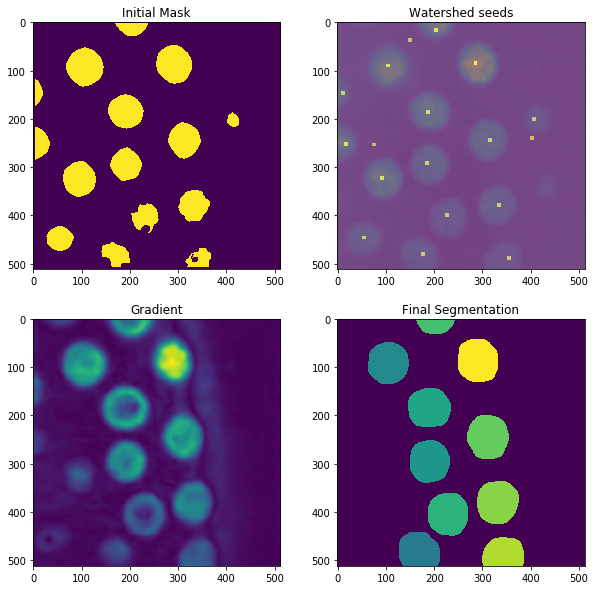

In [73]:
b=segment_nuclei3D_4(test, seed_window=(70,50,50), display=True)

OK! I'm saying nuclear segmentation is done for now (I've said it before though...). 

I commited and pushed the changes.

Polishing off: I need to update imfill so it won't pick a non-zero pixel by default. In its default (choose your own seed) mode, it starts with the top left (0,0) pixel (generalized to n-dimensions so it's the [0...0] dimension. Currently, if that pixel is one it just fails. I added the find_zero function to fix this behavior so it will search for a nearby 0 pixel.

In [49]:
def imfill(mask, seed_pt='default'):
    '''Fill holes within objects in a binary mask.
    
    Equivalent to matlab's imfill function. seed_pt needs to be a point in 
    the "background" area. All 0 or False pixels directly contiguous with 
    the seed are defined as background, all other pixels are declared foreground.
    Thus any "holes" (0 pixels that are not contiguous with background) are 
    filled in. Conceptually, this is like using the "fill" function in classic
    paint programs to fill the background, and taking all non-background as 
    foreground.
    
    Args:
        mask: ndarray
            Binary mask of n dimensions.
        seed_pt: tuple
            Pixel in mask to use for seeding "background". This is the equi-
            valent of the point you click when filling in paint. Default will
            start at the all top left ([0,0], [0,0,0], etc.) and select the
            first zero pixel on the top line from the left.
    
    Returns:
        mask_filled: ndarray
            Binary mask filled    
    '''
    # Find a zero pixel for default start in upper left corner. Begins at 0,0
    # and walks to the right until it finds a zero.
    def find_zero(mask):
        # Grab top line of first Z-slice.
        topline = mask[tuple(np.zeros(mask.ndim - 1).astype('int'))]
        # Find the first zero pixel from left.
        first_zero = np.where(topline == 0)[0][0]
        # Return this location as seed.
        seed_pt = tuple(np.zeros(mask.ndim - 1).astype(int)) + tuple([first_zero])
        return seed_pt
    # By default, start in upper left corner.
    if (seed_pt == 'default'):
        #seed_pt = tuple(np.zeros(mask.ndim).astype(int))
        seed_pt = find_zero(mask)
    # Fill all background pixels by changing them to 1. Changes are made to
    # original mask, so 1s are carried over in mask_flooded.
    mask_flooded = flood_fill(mask, seed_pt,1)
    # Identify background pixels by those that are changed from original mask.
    # Unchanged pixels (0s and 1s) in original mask are now "filled" foreground.
    mask_filled = np.where(mask == mask_flooded, 1, 0)
    return mask_filled

I added this to imp module and pushed.